In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
# Root directory for dataset
dataroot = "data/celeba"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 256

# Number of channels in the training images. For color images this is 3
nc = 3

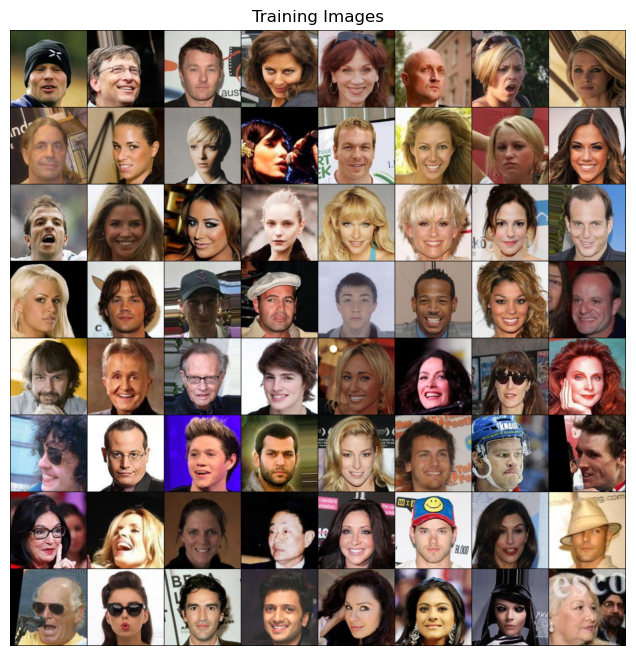

In [3]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [4]:
type(real_batch[0])

torch.Tensor

In [5]:
real_batch[0].shape

torch.Size([64, 3, 256, 256])

In [6]:
real_batch[0][0].shape

torch.Size([3, 256, 256])

In [7]:
img = real_batch[0][0]

In [8]:
x = img.unfold(1,64,64)
x = x.transpose(1, -1)
x.shape

torch.Size([3, 64, 256, 4])

In [9]:
x = x.unfold(2,64,64)
x = x.transpose(2, -1)
x.shape

torch.Size([3, 64, 64, 4, 4])

In [10]:
x = x.reshape(3*64*64, 4, 4)
x.shape

torch.Size([12288, 4, 4])

In [11]:
old_c, old_h, old_w = img.shape

In [12]:
old_c, old_h, old_w

(3, 256, 256)

In [13]:
img.shape == (3, 256, 256)

True

In [18]:
def img_patches(img: torch.Tensor, num_patches: int = 4) -> torch.Tensor:
    '''Splits img into num_patches * num_patches.
    
    Let width, height and channel be the width, height and channels of img. 
    The resulting tensor will be width/num_patches wide, height/num_patches high 
    and will have channels * num_patches * num_patches as the new channel dimension.
    '''
    old_c, old_h, old_w = img.shape
    new_h = old_h // num_patches
    new_w = old_w // num_patches
    new_c = old_c * num_patches * num_patches
    
    x = img

    # unfold height and width dimensions
    x = x.unfold(1, num_patches, num_patches)
    x = x.transpose(1, -1)
    x = x.unfold(2, num_patches, num_patches)
    x = x.transpose(2, -1)
    
    x = x.reshape((new_c, new_h, new_w))
    return x

In [15]:
img.shape

torch.Size([3, 256, 256])

In [19]:
img_test = img_patches(img)
img_test.shape

torch.Size([48, 64, 64])

In [ ]:
def combine_img_patches(img_patches: torch.Tensor, num_patches: int = 4) -> torch.Tensor:
    '''Combines the img_patches together to make one big image.
    
    Let width, height and channel be the width, height and channels of the img_patches.
    The resulting image will be width*num_patches wide, height*num_patches high
    and will have channels / (num_patches * num_patches) as the new channel dimension.
    Usually the new channel dimension should be 3 (RGB) or 1 (grayscale)
    '''
    old_c, old_h, old_w = img_patches.shape
    new_h = old_h * num_patches
    new_w = old_w *  num_patches
    new_c = old_c / (num_patches * num_patches)

    x = img_patches

    x.reshape(())

In [35]:
unfold = nn.Unfold(kernel_size=4, stride=4)
img_test = unfold(img)

In [36]:
img_test.shape

torch.Size([48, 4096])

In [37]:
img_first = real_batch[0][:1]
img_first.shape

torch.Size([1, 3, 256, 256])

In [38]:
img_test = unfold(img_first)
img_test.shape

torch.Size([1, 48, 4096])

In [39]:
from kornia.contrib import extract_tensor_patches, combine_tensor_patches

img_test = extract_tensor_patches(img_first, window_size=64, stride=64)

In [40]:
img_test.shape

torch.Size([1, 16, 3, 64, 64])

In [42]:
x = img_test.reshape((1, -1, 64, 64))
x.shape

torch.Size([1, 48, 64, 64])

In [50]:
y = x.reshape(1, 16, 3, 64, 64)
y.shape

torch.Size([1, 16, 3, 64, 64])

In [51]:
z = combine_tensor_patches(y, original_size=(256, 256), window_size=64, stride=64)

RuntimeError: shape '[-1, 64, 64, 3, 64, 64]' is invalid for input of size 196608

In [62]:
input = torch.arange(3*256**2).view(1, 3, 256, 256)
hidden_patches = extract_tensor_patches(input, window_size=(64, 64), stride=(64, 64))
print(hidden_patches.shape)
hidden_patches = hidden_patches.reshape((1, -1, 64, 64))
print(hidden_patches.shape)
hidden_patches = hidden_patches.reshape((1, -1, 3, 64, 64))
print(hidden_patches.shape)
output = combine_tensor_patches(hidden_patches, original_size=(256, 256), window_size=(4, 4), stride=(4, 4))
output.shape

torch.Size([1, 16, 3, 64, 64])
torch.Size([1, 48, 64, 64])
torch.Size([1, 16, 3, 64, 64])


torch.Size([1, 3, 256, 256])

In [60]:
input == output

tensor([[[[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]],

         [[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]],

         [[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ...

In [66]:
input = torch.arange(3*128**2).view(1, 3, 128, 128)
hidden_patches = extract_tensor_patches(input, window_size=32, stride=32)
print(hidden_patches.shape)
hidden_patches = hidden_patches.reshape((1, -1, 32, 32))
print(hidden_patches.shape)
hidden_patches = hidden_patches.reshape((1, -1, 3, 32, 32))
print(hidden_patches.shape)
output = combine_tensor_patches(hidden_patches, original_size=(128, 128), window_size=4, stride=4)
output.shape

torch.Size([1, 16, 3, 32, 32])
torch.Size([1, 48, 32, 32])
torch.Size([1, 16, 3, 32, 32])


torch.Size([1, 3, 128, 128])

In [64]:
input == output

tensor([[[[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]],

         [[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]],

         [[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ...